# Circle Detection하고 이를 위도/경도/utm-k로 변환하기
- utm-k에서 위도/경도로 변환하기 위한 pyproj 설치 필요
- (선택) 오프셋/스케일 맞추기 위한 foilum

In [2]:
import glob
import os

import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pyproj import Transformer

# 최소오차법으로 pixel값과 utm-k 사이 관계 (scale, offset) 구하기 (baseline)

...그리고 wgs84 (경도와 위도)로 변환

In [3]:
x = np.array(
    [
        3080.5,
        1665.5,
        2423.5,
        2987.5,
        2112.5,
        1971.5,
        2460.5,
        2364.5,
        2058.5,
        1862.5,
        2195.5,
        2659.5,
    ]
)
utmk_x = np.array(
    [
        947091.4280,
        941459.3332,
        944489.3207,
        946721.4400,
        943248.3213,
        942690.3195,
        944638.3312,
        944256.3442,
        943023.3416,
        942248.3293,
        943558.3837,
        945422.3998,
    ]
)

y = np.array(
    [
        1642.5,
        820.5,
        155.5,
        1900.5,
        372.5,
        425.5,
        360.5,
        626.5,
        751.5,
        651.5,
        1378.5,
        1391.5,
    ]
)
utmk_y = np.array(
    [
        1937405.6596,
        1940725.6015,
        1943184.6665,
        1936378.6467,
        1942504.6432,
        1942295.6323,
        1942548.6641,
        1941484.6495,
        1940993.6273,
        1941395.6187,
        1938481.6155,
        1938421.6431,
    ]
)

# x = x[1:]
# y = y[1:]
# utmk_x = utmk_x[1:]
# utmk_y = utmk_y[1:]

xw = np.sum((x - np.mean(x)) * (utmk_x - np.mean(utmk_x))) / np.sum(
    (x - np.mean(x)) ** 2
)
xb = np.mean(utmk_x) - xw * np.mean(x)
yw = np.sum((y - np.mean(y)) * (utmk_y - np.mean(utmk_y))) / np.sum(
    (y - np.mean(y)) ** 2
)
yb = np.mean(utmk_y) - yw * np.mean(y)


def px_to_utmk(px: np.ndarray) -> np.ndarray:
    # px.shape: [N, 2]
    res = px.copy()
    res[:, 0] = xb + px[:, 0] * xw
    res[:, 1] = yb + px[:, 1] * yw
    return res


transformer = Transformer.from_crs("EPSG:5178", "EPSG:4326", always_xy=True)


def px_to_wgs84(px: np.ndarray):
    res = px_to_utmk(px)
    x, y = transformer.transform(res[:, 0], res[:, 1])
    return np.stack([x, y], axis=-1)


print((xw, xb, yw, yb))

3.990911130401122 934605.59938452 -3.969044708950364 1944140.8608504923


# 인위적으로 구한 scale과 offset (실제로는 이거 사용)

아래 부록에 있는 최소오차법 코드의 결과를 바탕으로 실제 이미지와 비교하여 일일이 변경해가면서 적절하게 값을 조정하였음

In [118]:
xw = 3.9793797092726213 # 3.985 #3.9909
xb = 934837.1007872596 #934605.5994 + 220
yw = -4.010797509872257 #-4.005 #-3.9909
yb = 1944003.0407271045 #1944140.8609 + (-143)

def px_to_utmk(px:np.ndarray) -> np.ndarray:
    # px.shape: [N, 2]
    res = px.copy()
    res[:, 0] = xb + px[:, 0]*xw 
    res[:, 1] = yb + px[:, 1]*yw
    return res

transformer = Transformer.from_crs("EPSG:5178", "EPSG:4326", always_xy=True)
def px_to_wgs84(px:np.ndarray):
    res = px_to_utmk(px)
    x, y = transformer.transform(res[:, 0], res[:, 1])
    return np.stack([x, y], axis=-1)

print((xw, xb, yw, yb))

(3.9793797092726213, 934837.1007872596, -4.010797509872257, 1944003.0407271045)


~2017년 12월 까지는 행정구역이 달라서 그림이 틀어짐. 다른 변환 계수가 필요

In [119]:
xw_2017 = 3.992175103375879 #3.9909
xb_2017 = 934795.6904125963
yw_2017 = -3.999925425988266 #-4.005 #-3.9909
yb_2017 = 1943810.681402423 #1944140.8609 + (-143)

def px_to_utmk_2017(px:np.ndarray) -> np.ndarray:
    # px.shape: [N, 2]
    res = px.copy()
    res[:, 0] = xb_2017 + px[:, 0]*xw_2017 
    res[:, 1] = yb_2017 + px[:, 1]*yw_2017
    return res

transformer_2017 = Transformer.from_crs("EPSG:5178", "EPSG:4326", always_xy=True)
def px_to_wgs84_2017(px:np.ndarray):
    res = px_to_utmk_2017(px)
    x, y = transformer_2017.transform(res[:, 0], res[:, 1])
    return np.stack([x, y], axis=-1)

print((xw_2017, xb_2017, yw_2017, yb_2017))

(3.992175103375879, 934795.6904125963, -3.999925425988266, 1943810.681402423)


# 사고유형="전체" .csv 데이터 생성 

In [ ]:
la_accident = "전체"

list_imgname = glob.glob(f"figs/{la_accident}/*.png")
list_imgname.sort()
do_plotting = False
output_path = f"./data/사고지점_{la_accident}_2007_2023.csv"

data = []

for name_img in list_imgname:
    name_img = name_img.replace("\\", "/")
    img_point = plt.imread(name_img)
    date = name_img.split("/")[-1].split("_")[0][:6]
    year, month = date[:4], date[4:]
    # print(name_img)
    # 색상 변경
    img_point[:, :, 0] = img_point[:, :, 0] * img_point[:, :, 3]
    img_point[:, :, 1] = img_point[:, :, 1] * img_point[:, :, 3]
    img_point[:, :, 2] = img_point[:, :, 2] * img_point[:, :, 3]

    gray = cv2.cvtColor(img_point, cv2.COLOR_RGBA2GRAY)
    gray = (gray * 255).astype(np.uint8)
    circles = cv2.HoughCircles(
        gray, cv2.HOUGH_GRADIENT, 1, 3, param1=100, param2=10, minRadius=6, maxRadius=8
    )

    for circle in circles[0]:
        x, y, r = circle

        data.append([year, month, x, y, "{%s}" % la_accident])

    if do_plotting:
        x_range = [1000, 3267]
        y_range = [0, gray.shape[0]]

        plt.figure(figsize=[26, 18])

        # plt.subplot(2, 1, 1)
        plt.imshow(gray)
        plt.xlim(x_range)
        plt.ylim(
            y_range,
        )
        plt.gca().invert_yaxis()
        plt.gca().set_aspect(
            "equal",
        )
        plt.scatter(
            circles[0, :, 0],
            circles[0, :, 1],
            c=(1.0, 0.0, 0.0),
            s=0.5 * circles[0, :, 2],
        )
        plt.show()


df = pd.DataFrame(data, columns=["year", "month", "x", "y", "labels"])
utmk = px_to_utmk(df[["x", "y"]].to_numpy())
long_lati = px_to_wgs84(df[["x", "y"]].to_numpy())

# ~2017 12월까지의 데이터는 다른 계수로 사용해야 함. 이미지가 조금 틀어졌기 때문
mask = df["year"] < "2018"

utmk[mask] = px_to_utmk_2017(df[mask][["x", "y"]].to_numpy())
long_lati[mask] = px_to_wgs84_2017(df[mask][["x", "y"]].to_numpy())

df.insert(4, "utmk_x", utmk[:, 0])
df.insert(5, "utmk_y", utmk[:, 1])
df.insert(6, "longitude", long_lati[:, 0])
df.insert(7, "latitude", long_lati[:, 1])


df.to_csv(output_path)

# 각각의 사고 유형마다 읽어서 합쳐 저장하기

In [ ]:
list_accident = [
    "차대사람",
    "승합차",
    "이륜차",
    "택시",
    "신호위반",
    "화물차",
    "렌터카",
    "승용차",
    "차량단독",
    "시내버스",
    "고령운전자",
    "자전거",
    "원동기장치자전거",
    "음주운전",
    "사업용자동차",
]


list_imgname = glob.glob(f"figs/전체/*.png")
list_imgname.sort()
do_plotting = False
output_path = "./data/사고지점_통합_2007_2023.csv"


data = []

for name_img in list_imgname:
    name_img = name_img.replace("\\", "/")

    date = name_img.split("/")[-1].split("_")[0][:6]
    year, month = date[:4], date[4:]

    data_for_sort = []
    for i_acc, la_accident in enumerate(list_accident):
        # "전체"를 기준으로 이미지 리스트를 만들었기 때문에, 거기서 사고 이름만 바꿔서 이미지 경로를 만든다
        name_accimg = name_img.replace("전체", la_accident)
        img_point = plt.imread(name_accimg)

        # 색상 변경
        img_point[:, :, 0] = img_point[:, :, 0] * img_point[:, :, 3]
        img_point[:, :, 1] = img_point[:, :, 1] * img_point[:, :, 3]
        img_point[:, :, 2] = img_point[:, :, 2] * img_point[:, :, 3]

        gray = cv2.cvtColor(img_point, cv2.COLOR_RGBA2GRAY)
        gray = (gray * 255).astype(np.uint8)
        circles = cv2.HoughCircles(
            gray,
            cv2.HOUGH_GRADIENT,
            1,
            3,
            param1=100,
            param2=10,
            minRadius=6,
            maxRadius=8,
        )

        if circles is not None:
            for circle in circles[0]:
                x, y, r = circle

                data_for_sort.append([x, y, year, month, "{%s}" % la_accident])
    # 이웃한 점들의 좌표 계산을 위한 정렬
    data_for_sort.sort()
    lastData = None
    for newData in data_for_sort:
        # 이전 데이터가 없거나, 이전 데이터와의 좌표 차이가 유의미하게 클 때 새 데이터를 추가함.
        if (
            lastData is None
            or abs(newData[0] - lastData[0]) > 0.01
            or abs(newData[1] - lastData[1]) > 0.01
        ):
            # year, month, x, y, labels
            lastData = newData
            data.append(newData[2:4] + newData[:2] + newData[4:])
        else:  # 좌표 차이가 크지 않으므로 기존 데이터 (lastData)에 통합함
            # lastData가 바뀌지 않음에 유의. 즉 하나의 사고지점이 여러개의 label을 포함할 수 있도록 함.
            data[-1][4] += newData[4]

    if do_plotting:
        x_range = [1000, 3267]
        y_range = [0, gray.shape[0]]

        plt.figure(figsize=[26, 18])

        # plt.subplot(2, 1, 1)
        plt.imshow(gray)
        plt.xlim(x_range)
        plt.ylim(
            y_range,
        )
        plt.gca().invert_yaxis()
        plt.gca().set_aspect(
            "equal",
        )
        plt.scatter(
            circles[0, :, 0],
            circles[0, :, 1],
            c=(1.0, 0.0, 0.0),
            s=0.5 * circles[0, :, 2],
        )

        plt.show()


df = pd.DataFrame(data, columns=["year", "month", "x", "y", "labels"])
utmk = px_to_utmk(df[["x", "y"]].to_numpy())
long_lati = px_to_wgs84(df[["x", "y"]].to_numpy())


mask = df["year"] < "2018"

utmk[mask] = px_to_utmk_2017(df[mask][["x", "y"]].to_numpy())
long_lati[mask] = px_to_wgs84_2017(df[mask][["x", "y"]].to_numpy())

df.insert(4, "utmk_x", utmk[:, 0])
df.insert(5, "utmk_y", utmk[:, 1])
df.insert(6, "longitude", long_lati[:, 0])
df.insert(7, "latitude", long_lati[:, 1])

df.to_csv(output_path)

## 기존에 있던 데이터를 수정하는 코드

In [127]:
df = pd.read_csv("./data/사고지점_통합_2007_2023.csv")

df["year"] = df["year"].astype(str)
df["month"] = df["month"].apply(lambda x: f"{x:02d}")

utmk = px_to_utmk(df[["x", "y"]].to_numpy())
long_lati = px_to_wgs84(df[["x", "y"]].to_numpy())

mask = df["year"] < "2018"

utmk[mask] = px_to_utmk_2017(df[mask][["x", "y"]].to_numpy())
long_lati[mask] = px_to_wgs84_2017(df[mask][["x", "y"]].to_numpy())

df["utmk_x"] = utmk[:, 0]
df["utmk_y"] = utmk[:, 1]
df["longitude"] = long_lati[:, 0]
df["latitude"] = long_lati[:, 1]

df.to_csv("./data/사고지점_통합_2007_2023.csv", index=False)

# 
# ##########   부록   \############
# 

# 지도 그려보면서 오프셋/스케일 조절했던 부분
- 지도 그리는 코드가 꽤 아래에 있음
- 지도랑 TAAS랑 비교하면서 오프셋 조절했음

In [113]:
x = np.array(
    [
        3080.5,
        1665.5,
        2987.5,
        2112.5,
        1971.5,
        2460.5,
        2364.5,
        2058.5,
        1862.5,
        2195.5,
        2659.5,
    ]
)
utmk_x = np.array(
    [

        947091.4280,
        941459.3332,
        946721.4400,
        943248.3213,
        942690.3195,
        944638.3312,
        944256.3442,
        943023.3416,
        942248.3293,
        943558.3837,
        945422.3998,
    ]
)



y = np.array(
    [1642.5, 820.5, 1900.5, 372.5, 425.5, 360.5, 626.5, 751.5, 651.5, 1378.5, 1391.5]
)
utmk_y = np.array(
    [

        1937405.6596,
        1940725.6015,
        1936378.6467,
        1942504.6432,
        1942295.6323,
        1942548.6641,
        1941484.6495,
        1940993.6273,
        1941395.6187,
        1938481.6155,
        1938421.6431,
    ]
)

# x = x[1:]
# y = y[1:]
# utmk_x = utmk_x[1:]
# utmk_y = utmk_y[1:]

xw = np.sum((x - np.mean(x)) * (utmk_x - np.mean(utmk_x))) / np.sum(
    (x - np.mean(x)) ** 2
)
xb = np.mean(utmk_x) - xw * np.mean(x)

yw = np.sum((y - np.mean(y)) * (utmk_y - np.mean(utmk_y))) / np.sum(
    (y - np.mean(y)) ** 2
)
yb = np.mean(utmk_y) - yw * np.mean(y)


print((xw, xb, yw, yb))



def px_to_utmk(px: np.ndarray) -> np.ndarray:
    # px.shape: [N, 2]
    res = px.copy()
    res[:, 0] = xb + px[:, 0] * xw
    res[:, 1] = yb + px[:, 1] * yw
    return res



transformer = Transformer.from_crs("EPSG:5178", "EPSG:4326", always_xy=True)


def px_to_wgs84(px: np.ndarray):
    res = px_to_utmk(px)
    x, y = transformer.transform(res[:, 0], res[:, 1])
    return np.stack([x, y], axis=-1)



utmk = px_to_utmk(df[["x", "y"]].to_numpy())
long_lati = px_to_wgs84(df[["x", "y"]].to_numpy())
df["utmk_x"] = utmk[:, 0]
df["utmk_y"] = utmk[:, 1]


df["longitude"] = long_lati[:, 0]
df["latitude"] = long_lati[:, 1]

(3.9793797092726213, 934837.1007872596, -4.010797509872257, 1944003.0407271045)


In [101]:
xw = 3.9793797092726213  # 3.985 #3.9909
xb = 934837.1007872596  # 934605.5994 + 220
yw = -4.010797509872257  # -4.005 #-3.9909
yb = 1944003.0407271045  # 1944140.8609 + (-143)


def px_to_utmk(px: np.ndarray) -> np.ndarray:
    # px.shape: [N, 2]
    res = px.copy()
    res[:, 0] = xb + px[:, 0] * xw
    res[:, 1] = yb + px[:, 1] * yw
    return res


transformer = Transformer.from_crs("EPSG:5178", "EPSG:4326", always_xy=True)


def px_to_wgs84(px: np.ndarray):
    res = px_to_utmk(px)
    x, y = transformer.transform(res[:, 0], res[:, 1])
    return np.stack([x, y], axis=-1)


print((xw, xb, yw, yb))

utmk = px_to_utmk(df[["x", "y"]].to_numpy())
long_lati = px_to_wgs84(df[["x", "y"]].to_numpy())
df["utmk_x"] = utmk[:, 0]
df["utmk_y"] = utmk[:, 1]
df["longitude"] = long_lati[:, 0]
df["latitude"] = long_lati[:, 1]

(3.979791158442431, 934836.8289222205, -3.993695147911345, 1943997.2399637224)


## ~2017 12월

In [53]:
x = np.array(
    [
        2100.5,
        2242.5,
        1826.5,
        2476.5,
        2527.5,
        2795.5,
        2628.5,
        2130.5,
        2006.5,
        2679.5,
        1968.5,
    ]
)
utmk_x = np.array(
    [
        943203.3223,
        943743.4032,
        942098.3305,
        944677.3888,
        944897.3438,
        945959.3781,
        945286.4180,
        943307.1430,
        942800.3869,
        945484.4386,
        942626.4259,
    ]
)

y = np.array(
    [356.5, 1630.5, 645.5, 1268.5, 495.5, 920.5, 1678.5, 682.5, 1485.5, 1983.5, 2149.5]
)
utmk_y = np.array(
    [
        1942388.6413,
        1937289.6087,
        1941237.6154,
        1938734.6342,
        1941821.6626,
        1940119.6642,
        1937091.6303,
        1941083.2321,
        1937874.5989,
        1935869.6238,
        1935221.5755,
    ]
)

# x = x[1:]
# y = y[1:]
# utmk_x = utmk_x[1:]
# utmk_y = utmk_y[1:]

xw = np.sum((x - np.mean(x)) * (utmk_x - np.mean(utmk_x))) / np.sum(
    (x - np.mean(x)) ** 2
)
xb = np.mean(utmk_x) - xw * np.mean(x)
yw = np.sum((y - np.mean(y)) * (utmk_y - np.mean(utmk_y))) / np.sum(
    (y - np.mean(y)) ** 2
)
yb = np.mean(utmk_y) - yw * np.mean(y)


def px_to_utmk(px: np.ndarray) -> np.ndarray:
    # px.shape: [N, 2]
    res = px.copy()
    res[:, 0] = xb + px[:, 0] * xw
    res[:, 1] = yb + px[:, 1] * yw
    return res


transformer = Transformer.from_crs("EPSG:5178", "EPSG:4326", always_xy=True)


def px_to_wgs84(px: np.ndarray):
    res = px_to_utmk(px)
    x, y = transformer.transform(res[:, 0], res[:, 1])
    return np.stack([x, y], axis=-1)


print((xw, xb, yw, yb))

utmk = px_to_utmk(df[["x", "y"]].to_numpy())
long_lati = px_to_wgs84(df[["x", "y"]].to_numpy())
df["utmk_x"] = utmk[:, 0]
df["utmk_y"] = utmk[:, 1]
df["longitude"] = long_lati[:, 0]
df["latitude"] = long_lati[:, 1]

(3.992175103375879, 934795.6904125963, -3.999925425988266, 1943810.681402423)


In [ ]:
xw = 3.992175103375879  # 3.9909
xb = 934795.6904125963
yw = -3.999925425988266  # -4.005 #-3.9909
yb = 1943810.681402423  # 1944140.8609 + (-143)


def px_to_utmk(px: np.ndarray) -> np.ndarray:
    # px.shape: [N, 2]
    res = px.copy()
    res[:, 0] = xb + px[:, 0] * xw
    res[:, 1] = yb + px[:, 1] * yw
    return res


transformer = Transformer.from_crs("EPSG:5178", "EPSG:4326", always_xy=True)


def px_to_wgs84(px: np.ndarray):
    res = px_to_utmk(px)
    x, y = transformer.transform(res[:, 0], res[:, 1])
    return np.stack([x, y], axis=-1)


print((xw, xb, yw, yb))

utmk = px_to_utmk(df[["x", "y"]].to_numpy())
long_lati = px_to_wgs84(df[["x", "y"]].to_numpy())
df["utmk_x"] = utmk[:, 0]
df["utmk_y"] = utmk[:, 1]
df["longitude"] = long_lati[:, 0]
df["latitude"] = long_lati[:, 1]

## 비교용 시각화

In [ ]:
import folium
import datetime
import json

with open("시군구/sig_광명시_epsg4326.geojson", encoding="UTF-8") as file:
    sig_json = json.load(file)

selected_data = df[(df["year"] == "2019") & (df["month"] < "07")]

utmk = selected_data[["utmk_x","utmk_y"]].to_numpy()


def color_function(value:float) -> str:
    red = int(min(255, 512*value))
    blue = int(min(255, 512*(1-value)))
    return f"#{red:0>2x}00{blue:0>2x}"


death_when = selected_data[["year", "month"]].to_numpy()
deathtime_list = [datetime.datetime.strptime(str(y)+str(m), "%Y%m").timestamp() for y, m in death_when]

first_dtime = min(deathtime_list)
last_dtime = max(deathtime_list)

min_long = min(selected_data["longitude"])
max_long = max(selected_data["longitude"])

min_lant = min(selected_data["latitude"])
max_lant = max(selected_data["latitude"])

x, y = selected_data["longitude"].to_numpy(), selected_data["latitude"].to_numpy()
m = folium.Map(location=((min_lant+max_lant)/2, (min_long+max_long)/2), zoom_start=13)

folium.GeoJson(
    sig_json,
    name="광명시",
).add_to(m)

death_markers = folium.FeatureGroup("교통사고").add_to(m)

for i in range(len(x)):
    dtime = deathtime_list[i]
    #c_str = color_function((dtime-first_dtime)/(last_dtime-first_dtime))
    c_str = "#FF0000"
    ddate_str = str(death_when[i][0]+death_when[i][1])
    popup = f"사고시간:{ddate_str[:4]}년 {ddate_str[4:6]}월 {ddate_str[6:8]}일 {ddate_str[8:]}시, 경도:{x[i]:.2f}, 위도:{y[i]:.2f} x:{utmk[i,0]:.2f}, y:{utmk[i, 1]:.2f}"
    folium.Marker((y[i], x[i]), tooltip=popup, icon=folium.Icon("white",c_str, icon="skull-crossbones", prefix="fa")).add_to(death_markers)

folium.LayerControl().add_to(m)

m

# 픽셀 => utm-k 변환용 n개 점 찾기 => 최소오차법 사용

In [ ]:
df = pd.read_csv("./data/사고지점_통합_2007_2023.csv")

df["year"] = df["year"].astype(str)
df["month"] = df["month"].apply(lambda x: f"{x:02d}")

In [18]:

tmp = df[(df["year"] == "2018") & (df["month"]== "04")]
tmp[tmp["x"] == max(tmp["x"] )]

# x:3080.5 == 경도:126.89978282 = utmk_x:947091.4280
# y:1642.5 == 위도:37.43705369 = utmk_y:1937405.6596



,year,month,x,y,utmk_x,utmk_y,longitude,latitude,labels
10308,2018,04,3080.5,1642.5,946222.5,1937677.625,126.889941,37.439455,{승용차}{택시}


In [9]:
tmp = df[(df["year"] == "2023") & (df["month"]== "09")]
tmp[tmp["x"] == min(tmp["x"])]

# x:1665.5 = utmk_x:941459.3332
# y:820.5 = utmk_y:1940725.6015

 

,year,month,x,y,utmk_x,utmk_y,longitude,latitude,labels
15799,2023,09,1665.5,820.5,941462.625,1940711.75,126.835897,37.466512,{고령운전자}{승용차}{차량단독}


In [249]:
tmp = df[df["date"] == "201810"]
tmp[tmp["x"] == np.sort(tmp["x"])[-2]]

# x:2987.5 = utmk_x: 946721.4400
# y:1900.5 = utmk_y: 1936378.6467

,date,x,y
9974,201810,2987.5,1900.5


In [24]:
tmp = df[(df["year"] == "2019") & (df["month"] == "05")]
tmp[tmp["y"] == np.sort(tmp["y"])[5]]
f
# x:2112.5 = utmk_x: 943248.3213
# y:372.5 = utmk_y: 1942504.6432

,year,month,x,y,utmk_x,utmk_y,longitude,latitude,labels
11430,2019,05,2112.5,372.5,942602.0,1942711.75,126.848624,37.48461,{승용차}


In [76]:
tmp = df[(df["year"] == "2023") & (df["month"] == "12")]
tmp[tmp["y"] == np.sort(tmp["y"])[10]]
# x:1971.5 = utmk_x: 942690.3195
# y:425.5 = utmk_y: 1942295.6323

,year,month,x,y,utmk_x,utmk_y,longitude,latitude,labels
16097,2023,12,1971.5,425.5,942683.125,1942221.25,126.84958,37.480194,{차대사람}


In [18]:
tmp = df[(df["year"] == "2022") & (df["month"] == "05")]
tmp[(2450 < tmp["x"]) & (tmp["x"] < 2470) & (352 < tmp["y"]) & (tmp["y"] < 383)]
# x:2460.5 = utmk_x: 944638.3312
# y:360.5 = utmk_y: 1942548.6641

,Unnamed: 0,year,month,x,y,utmk_x,utmk_y,longitude,latitude,labels
14501,14501,2022,05,2460.5,360.5,944630.7,1942554.1,126.871581,37.483313,{고령운전자}{승합차}{신호위반}
14502,14502,2022,05,2460.5,374.5,944630.7,1942498.0,126.871585,37.482807,{고령운전자}{승용차}


In [23]:
tmp = df[(df["year"] == "2022") & (df["month"] == "01")]
tmp[(2360 < tmp["x"]) & (tmp["x"] < 2370) & (618 < tmp["y"]) & (tmp["y"] < 638)]
# x:2364.5 = utmk_x: 944256.3442
# y:626.5 = utmk_y: 1941484.6495

,Unnamed: 0,year,month,x,y,utmk_x,utmk_y,longitude,latitude,labels
14157,14157,2022,01,2364.5,626.5,944248.2,1941488.8,126.867336,37.473688,{승합차}{시내버스}{차대사람}


In [24]:
tmp = df[(df["year"] == "2022") & (df["month"] == "11")]
tmp[(2045 < tmp["x"]) & (tmp["x"] < 2065) & (744 < tmp["y"]) & (tmp["y"] < 764)]
# x:2058.5 = utmk_x: 943023.3416
# y:751.5 = utmk_y: 1940993.6273

,Unnamed: 0,year,month,x,y,utmk_x,utmk_y,longitude,latitude,labels
14949,14949,2022,11,2058.5,751.5,943028.75,1940988.1,126.853584,37.469101,{고령운전자}{승합차}{신호위반}{이륜차}


In [25]:
tmp = df[(df["year"] == "2022") & (df["month"] == "07")]
tmp[(1856 < tmp["x"]) & (tmp["x"] < 1870) & (642 < tmp["y"]) & (tmp["y"] < 656)]
# x:1862.5 = utmk_x: 942248.3293
# y:651.5 = utmk_y: 1941395.6187

,Unnamed: 0,year,month,x,y,utmk_x,utmk_y,longitude,latitude,labels
14620,14620,2022,07,1862.5,651.5,942247.7,1941388.6,126.844721,37.472662,{승용차}{차대사람}{택시}


In [27]:
tmp = df[(df["year"] == "2022") & (df["month"] == "01")]
tmp[(2185 < tmp["x"]) & (tmp["x"] < 2205) & (1369 < tmp["y"]) & (tmp["y"] < 1389)]
# x:2195.5 = utmk_x: 943558.3837
# y:1378.5 = utmk_y: 1938481.6155

,Unnamed: 0,year,month,x,y,utmk_x,utmk_y,longitude,latitude,labels
14151,14151,2022,01,2195.5,1378.5,943574.7,1938477.0,126.85995,37.446502,{음주운전}{화물차}


In [28]:
tmp = df[(df["year"] == "2022") & (df["month"] == "02")]
tmp[(2651 < tmp["x"]) & (tmp["x"] < 2671) & (1382 < tmp["y"]) & (tmp["y"] < 1402)]
# x:2659.5 = utmk_x: 945422.3998
# y:1391.5 = utmk_y: 1938421.6431

,Unnamed: 0,year,month,x,y,utmk_x,utmk_y,longitude,latitude,labels
14256,14256,2022,02,2659.5,1391.5,945423.75,1938424.9,126.880857,37.446143,{승용차}{신호위반}{음주운전}{차대사람}


In [110]:
x = np.array(
    [
        3080.5,
        1665.5,
        2987.5,
        2112.5,
        1971.5,
        2460.5,
        2364.5,
        2058.5,
        1862.5,
        2195.5,
        2659.5,
    ]
)
utmk_x = np.array(
    [
        947091.4280,
        941459.3332,
        946721.4400,
        943248.3213,
        942690.3195,
        944638.3312,
        944256.3442,
        943023.3416,
        942248.3293,
        943558.3837,
        945422.3998,
    ]
)

y = np.array(
    [
        1642.5, 
        820.5,
        1900.5,
        372.5,
        425.5,
        360.5, 626.5, 751.5, 651.5, 1378.5, 1391.5]
)
utmk_y = np.array(
    [
        1937405.6596,
        1940725.6015,
        1936378.6467,
        1942504.6432,
        1942295.6323,
        1942548.6641,
        1941484.6495,
        1940993.6273,
        1941395.6187,
        1938481.6155,
        1938421.6431,
    ]
)

# x = x[1:]
# y = y[1:]
# utmk_x = utmk_x[1:]
# utmk_y = utmk_y[1:]

xw = np.sum((x - np.mean(x)) * (utmk_x - np.mean(utmk_x))) / np.sum(
    (x - np.mean(x)) ** 2
)
xb = np.mean(utmk_x) - xw * np.mean(x)
yw = np.sum((y - np.mean(y)) * (utmk_y - np.mean(utmk_y))) / np.sum(
    (y - np.mean(y)) ** 2
)
yb = np.mean(utmk_y) - yw * np.mean(y)


def px_to_utmk(px: np.ndarray) -> np.ndarray:
    # px.shape: [N, 2]
    res = px.copy()
    res[:, 0] = xb + px[:, 0] * xw
    res[:, 1] = yb + px[:, 1] * yw
    return res


transformer = Transformer.from_crs("EPSG:5178", "EPSG:4326", always_xy=True)


def px_to_wgs84(px: np.ndarray):
    res = px_to_utmk(px)
    x, y = transformer.transform(res[:, 0], res[:, 1])
    return np.stack([x, y], axis=-1)


xw, xb, yw, yb

(3.9793797092726213, 934837.1007872596, -4.010797509872257, 1944003.0407271045)

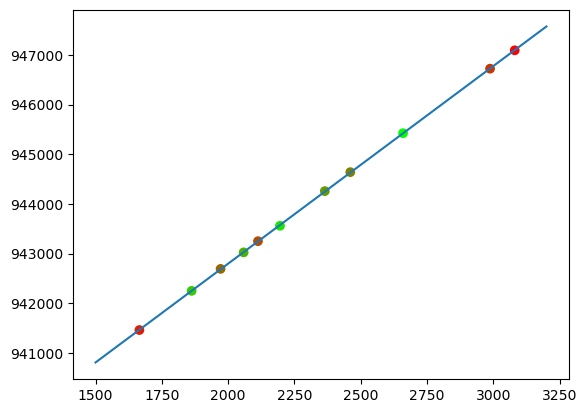

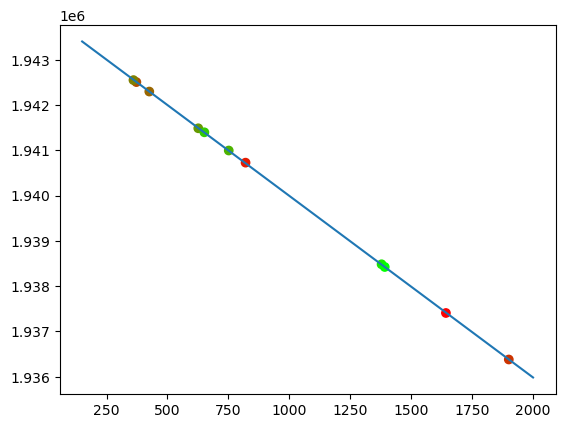

In [111]:
import matplotlib.pyplot as plt

xx = [1500, 3200]
yy = [ xw*xi+xb for xi in xx]
plt.scatter(x, utmk_x, c=[(1-i/(len(x)-1), i/(len(x)-1), 0) for i in range(len(x))])
plt.plot(xx, yy)
plt.show()

xx = [150, 2000]
yy = [ yw*xi+yb for xi in xx]
plt.scatter(y, utmk_y, c=[(1-i/(len(y)-1), i/(len(y)-1), 0) for i in range(len(y))])
plt.plot(xx, yy)
plt.show()

# (~2017/12월) 변환용 점 찾기 => 최소오차법 사용

In [ ]:
df = pd.read_csv("./data/사고지점_통합_2007_2023.csv")

df["year"] = df["year"].astype(str)
df["month"] = df["month"].apply(lambda x: f"{x:02d}")

In [33]:
tmp = df[(df["year"] == "2015") & (df["month"]== "01")]
tmp[(2091<tmp["x"]) & (tmp["x"]<2111) & (348<tmp["y"]) & (tmp["y"]<368)]
# x:2100.5 = utmk_x: 943203.3223
# y:356.5 = utmk_y: 1942388.6413

,Unnamed: 0,year,month,x,y,utmk_x,utmk_y,longitude,latitude,labels
6696,6696,2015,01,2100.5,356.5,943196.380251,1.942537e+06,126.85536,37.483067,{이륜차}{차대사람}


In [37]:
tmp = df[(df["year"] == "2015") & (df["month"]== "01")]
tmp[(2234<tmp["x"]) & (tmp["x"]<2254) & (1622<tmp["y"]) & (tmp["y"]<1652)]
# x:2242.5 = utmk_x: 943743.4032
# y:1630.5 = utmk_y: 1937289.6087

,Unnamed: 0,year,month,x,y,utmk_x,utmk_y,longitude,latitude,labels
6703,6703,2015,01,2242.5,1630.5,943761.510595,1.937477e+06,126.862139,37.437502,{승용차}{차대사람}{택시}


In [38]:
tmp = df[(df["year"] == "2015") & (df["month"]== "03")]
tmp[(1818<tmp["x"]) & (tmp["x"]<1838) & (637<tmp["y"]) & (tmp["y"]<657)]
# x:1826.5 = utmk_x: 942098.3305
# y:645.5 = utmk_y: 1941237.6154

,Unnamed: 0,year,month,x,y,utmk_x,utmk_y,longitude,latitude,labels
6823,6823,2015,03,1826.5,645.5,942105.917473,1.941389e+06,126.843117,37.472655,{고령운전자}{이륜차}{차량단독}


In [39]:
tmp = df[(df["year"] == "2015") & (df["month"]== "04")]
tmp[(2465<tmp["x"]) & (tmp["x"]<2485) & (1259<tmp["y"]) & (tmp["y"]<1279)]
# x:2476.5 = utmk_x: 944677.3888
# y:1268.5 = utmk_y: 1938734.6342

,Unnamed: 0,year,month,x,y,utmk_x,utmk_y,longitude,latitude,labels
6984,6984,2015,04,2476.5,1268.5,944692.781726,1.938915e+06,126.872557,37.450515,{사업용자동차}{화물차}


In [40]:
tmp = df[(df["year"] == "2015") & (df["month"]== "04")]
xx = 2525
yy = 496
tmp[(xx-10<tmp["x"]) & (tmp["x"]<xx+10)
    & (yy-10<tmp["y"]) & (tmp["y"]<yy+10)]
# x:2527.5 = utmk_x: 944897.3438
# y:495.5 = utmk_y: 1941821.6626

,Unnamed: 0,year,month,x,y,utmk_x,utmk_y,longitude,latitude,labels
6988,6988,2015,04,2527.5,495.5,944895.751075,1.941985e+06,126.874622,37.478195,{승용차}{이륜차}


In [42]:
tmp = df[(df["year"] == "2015") & (df["month"]== "12")]
xx = 2794
yy = 922
tmp[(xx-10<tmp["x"]) & (tmp["x"]<xx+10)
    & (yy-10<tmp["y"]) & (tmp["y"]<yy+10)]
# x:2795.5 = utmk_x: 945959.3781
# y:920.5 = utmk_y: 1940119.6642

,Unnamed: 0,year,month,x,y,utmk_x,utmk_y,longitude,latitude,labels
7911,7911,2015,12,2795.5,920.5,945962.335106,1.940297e+06,126.886808,37.463046,{이륜차}


In [43]:
tmp = df[(df["year"] == "2015") & (df["month"]== "12")]
xx = 2630
yy = 1678
tmp[(xx-10<tmp["x"]) & (tmp["x"]<xx+10)
    & (yy-10<tmp["y"]) & (tmp["y"]<yy+10)]
# x:2628.5 = utmk_x: 945286.4180
# y:1678.5 = utmk_y: 1937091.6303

,Unnamed: 0,year,month,x,y,utmk_x,utmk_y,longitude,latitude,labels
7881,7881,2015,12,2628.5,1678.5,945297.709982,1.937287e+06,126.879517,37.435876,{사업용자동차}{차대사람}{화물차}


In [45]:
tmp = df[(df["year"] == "2012") & (df["month"]== "01")]
xx = 2129
yy = 684
tmp[(xx-10<tmp["x"]) & (tmp["x"]<xx+10)
    & (yy-10<tmp["y"]) & (tmp["y"]<yy+10)]
# x:2130.5 = utmk_x: 943307.1430
# y:682.5 = utmk_y: 1941083.2321

,Unnamed: 0,year,month,x,y,utmk_x,utmk_y,longitude,latitude,labels
4123,4123,2012,01,2130.5,682.5,943315.773985,1.941242e+06,126.85681,37.471406,{승용차}{택시}


In [46]:
tmp = df[(df["year"] == "2012") & (df["month"]== "01")]
xx = 2007
yy = 1486
tmp[(xx-10<tmp["x"]) & (tmp["x"]<xx+10)
    & (yy-10<tmp["y"]) & (tmp["y"]<yy+10)]
# x:2006.5 = utmk_x: 942800.3869
# y:1485.5 = utmk_y: 1937874.5989

,Unnamed: 0,year,month,x,y,utmk_x,utmk_y,longitude,latitude,labels
4114,4114,2012,01,2006.5,1485.5,942822.279882,1.938053e+06,126.851477,37.442634,{차량단독}{화물차}


In [48]:
tmp = df[(df["year"] == "2012") & (df["month"]== "01")]
xx = 2680
yy = 1985
tmp[(xx-10<tmp["x"]) & (tmp["x"]<xx+10)
    & (yy-10<tmp["y"]) & (tmp["y"]<yy+10)]
# x:2679.5 = utmk_x: 945484.4386
# y:1983.5 = utmk_y: 1935869.6238

,Unnamed: 0,year,month,x,y,utmk_x,utmk_y,longitude,latitude,labels
4161,4161,2012,01,2679.5,1983.5,945500.679331,1.936075e+06,126.881901,37.424971,{승합차}{시내버스}{차대사람}


In [50]:
tmp = df[(df["year"] == "2012") & (df["month"]== "07")]
xx = 1968
yy = 2151
tmp[(xx-10<tmp["x"]) & (tmp["x"]<xx+10)
    & (yy-10<tmp["y"]) & (tmp["y"]<yy+10)]
# x:1968.5 = utmk_x: 942626.4259
# y:2149.5 = utmk_y: 1935221.5755

,Unnamed: 0,year,month,x,y,utmk_x,utmk_y,longitude,latitude,labels
4518,4518,2012,07,1968.5,2149.5,942671.047818,1.935416e+06,126.849973,37.418858,{사업용자동차}{화물차}


In [51]:
x = np.array([2100.5, 2242.5, 1826.5, 2476.5, 2527.5, 2795.5, 2628.5, 2130.5, 2006.5, 2679.5, 1968.5])
utmk_x = np.array([943203.3223, 943743.4032, 942098.3305, 944677.3888, 944897.3438, 945959.3781, 945286.4180, 943307.1430, 942800.3869, 945484.4386, 942626.4259])

y = np.array([356.5, 1630.5, 645.5, 1268.5, 495.5, 920.5, 1678.5, 682.5, 1485.5, 1983.5, 2149.5])
utmk_y = np.array([1942388.6413, 1937289.6087, 1941237.6154, 1938734.6342, 1941821.6626, 1940119.6642, 1937091.6303, 1941083.2321, 1937874.5989, 1935869.6238, 1935221.5755])

#x = x[1:]
#y = y[1:]
#utmk_x = utmk_x[1:]
#utmk_y = utmk_y[1:]

xw = np.sum((x - np.mean(x))*(utmk_x - np.mean(utmk_x)))/np.sum((x - np.mean(x))**2)
xb = np.mean(utmk_x) - xw*np.mean(x)
yw = np.sum((y - np.mean(y))*(utmk_y - np.mean(utmk_y)))/np.sum((y - np.mean(y))**2)
yb = np.mean(utmk_y) - yw*np.mean(y)

def px_to_utmk(px:np.ndarray) -> np.ndarray:
    # px.shape: [N, 2]
    res = px.copy()
    res[:, 0] = xb + px[:, 0]*xw 
    res[:, 1] = yb + px[:, 1]*yw
    return res

transformer = Transformer.from_crs("EPSG:5178", "EPSG:4326", always_xy=True)
def px_to_wgs84(px:np.ndarray):
    res = px_to_utmk(px)
    x, y = transformer.transform(res[:, 0], res[:, 1])
    return np.stack([x, y], axis=-1)

xw, xb, yw, yb

(3.992175103375879, 934795.6904125963, -3.999925425988266, 1943810.681402423)

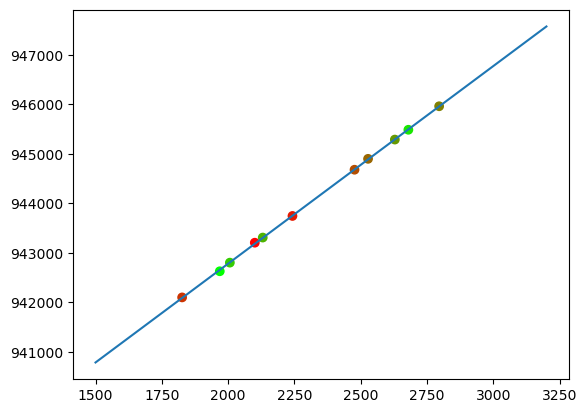

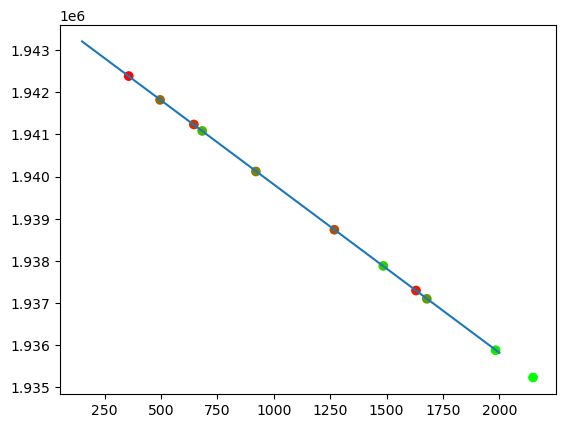

In [52]:
import matplotlib.pyplot as plt

xx = [1500, 3200]
yy = [ xw*xi+xb for xi in xx]
plt.scatter(x, utmk_x, c=[(1-i/(len(x)-1), i/(len(x)-1), 0) for i in range(len(x))])
plt.plot(xx, yy)
plt.show()

xx = [150, 2000]
yy = [ yw*xi+yb for xi in xx]
plt.scatter(y, utmk_y, c=[(1-i/(len(y)-1), i/(len(y)-1), 0) for i in range(len(y))])
plt.plot(xx, yy)
plt.show()